## Q2 What pricing strategies can we implement to maximize revenue?
In this notebook, we'll be exploring the price elasticities for the different product categories. Price elasticity is a measure of the effect of a price change on the demand for a product or service. It follows the formula of percentage change in quantity demanded of a good divided by the percentage change in its price.

In [2]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 10000)

client = bigquery.Client(project="plucky-snowfall-438110-f2")

## 1. Querying product sales from GA

In [4]:
query = '''
    WITH purchases as(
        SELECT distinct
            fullVisitorId as user_id
            ,PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) AS datetime
            ,product.productSKU AS product_id
            ,product.v2ProductName AS product_name
            ,product.v2ProductCategory AS product_category
            ,product.productPrice/1000000 AS product_price
            ,product.productQuantity AS product_qty
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        LEFT JOIN UNNEST(hits.product) AS product ON TRUE
        WHERE true
            and hits.eCommerceAction.action_type  = '6'
            and product.productQuantity > 0
            and PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) < date '2017-08-01'
    )
    SELECT 
        date_trunc(datetime, day) as ymd
        ,product_id
        ,product_name
        ,product_category product_category_temp
        ,product_price
        ,sum(product_qty) as daily_qty
        ,count(distinct user_id) as daily_user_cnt
    FROM purchases
    GROUP BY 2,1,3,4,5
    ORDER BY 1,2,3
    
'''

rows = client.query(query)
daily_sales = rows.to_dataframe()
raw_ga_data = rows.to_dataframe()

In [5]:
daily_sales["ymd"] = pd.to_datetime(daily_sales["ymd"])
daily_sales.replace('(not set)', np.nan, inplace = True)
daily_sales['product_category_temp'].replace('${productitem.product.origCatName}', np.nan, inplace = True)
daily_sales['product_category_temp'].replace(['Tumblers', 'Bottles', 'Google'], 'Drinkware', inplace = True)
daily_sales['product_category_temp'].replace(['More Bags', 'Backpacks'], 'Bags', inplace = True)
daily_sales['product_category_temp'].replace('Android', 'Apparel', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"Waze.*(Men's|Women's|Socks)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales['product_category_temp'].replace('Waze', 'Office', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"(Shirt|Sleeve|Tee|Jacket|Pullover|Hoodie|Tank|Vest|Onesie|Pants|Hood|Polo)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales.loc[daily_sales["product_name"].str.contains(r"(oz|Bottle|Cup)", case = True, na = False), "product_category_temp"] = "Drinkware"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Journal|Notebook", case = True, na = False), "product_category_temp"] = "Notebooks & Journals"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Bag|Backpack|Tote|Rucksack", case = True, na = False), "product_category_temp"] = "Bags"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Gift Card", case = True, na = False), "v"] = "Gift Cards"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Electronics|Device|Headphones|Earbuds|Earphones", case = True, na = False), "product_category_temp"] = "Electronics"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Cap|Hat", case = True, na = False), "product_category_temp"] = "Headgear"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Pen", case = True, na = False), "product_category_temp"] = "Office"
daily_sales["product_id"] = daily_sales['product_id'].astype("string")
product_category_mode = daily_sales.groupby(["product_id", "product_price"])["product_category_temp"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(name="product_category")
daily_sales = daily_sales.merge(product_category_mode, on = ["product_id", "product_price"], how = "left")
daily_sales = daily_sales.groupby(["ymd", "product_id", "product_price", "product_category"])[["daily_qty", "daily_user_cnt"]].sum().reset_index()

daily_sales.dropna(subset = ['product_category'], inplace = True)

## 2. Grouping by product category and month

Grouped by months since Synthetic Data is only available in Months.

In [8]:
# Convert 'ymd' to monthly periods to group by month
daily_sales['month'] = daily_sales['ymd'].dt.to_period('M')

# Group by 'month' and 'product_category', and calculate the mean price and total quantity
monthly_category_sales = daily_sales.groupby(['month', 'product_category']).agg(
    mean_price=('product_price', 'mean'),  # Mean price per month for each category
    total_qty=('daily_qty', 'sum')         # Total quantity sold per month for each category
).reset_index()

# Display the grouped data
monthly_category_sales.head()

,month,product_category,mean_price,total_qty
0,2016-08,Accessories,4.427500,23
1,2016-08,Apparel,23.618907,2366
2,2016-08,Bags,33.278173,1277
3,2016-08,Drinkware,9.498481,4964
4,2016-08,Electronics,22.128962,1510


## 3. Importing Synthetic Data

In [10]:
file_path = "..\Q1\DemandForecasting\data\cleaned_synthetic_apr_jul.csv"
synthetic_sales_data = pd.read_csv(file_path)
synthetic_sales_data

,year_month,product_id,product_category,product_price,present_user_cnt,present_total_qty
0,2016-04-01,GGOEAOBH078799,Fun,8.99,36,108
1,2016-04-01,GGOEAOBH078799,Accessories,7.19,3,3
2,2016-04-01,GGOEGAAB010517,Apparel,16.99,4,4
3,2016-04-01,GGOEGAAB010517,Apparel,13.59,3,9
4,2016-04-01,GGOEGAAC032117,Apparel,18.99,4,4
...,...,...,...,...,...,...
3876,2016-07-01,GGOEGAEJ028115,Apparel,4.08,0,0
3877,2016-07-01,GGOEGALJ057913,Apparel,22.00,0,0
3878,2016-07-01,GGOEYAEA035116,Apparel,12.00,0,0
3879,2016-07-01,GGOEYAEJ029015,Apparel,18.99,0,0


## 4. Formatting Synthetic Data

In [12]:
# Step 1: Convert 'year_month' to a datetime format if it's not already
synthetic_sales_data['year_month'] = pd.to_datetime(synthetic_sales_data['year_month'])

# Step 2: Create a 'month' column in the format 'YYYY-MM' for consistency
synthetic_sales_data['month'] = synthetic_sales_data['year_month'].dt.to_period('M').astype(str)

# Step 3: Group by 'month' and 'product_category', calculating mean price and total quantity
synthetic_sales_summary = synthetic_sales_data.groupby(['month', 'product_category']).agg(
    mean_price=('product_price', 'mean'),    # Mean price for each category per month
    total_qty=('present_total_qty', 'sum')   # Total quantity for each category per month
).reset_index()

# Display the transformed synthetic data
synthetic_sales_summary.head()


,month,product_category,mean_price,total_qty
0,2016-04,Accessories,8.430000,132
1,2016-04,Apparel,23.892972,2627
2,2016-04,Bags,41.604857,1269
3,2016-04,Drinkware,11.802075,3268
4,2016-04,Electronics,28.293000,655


## 5. Combining Original Data with Synthetic Data

In [14]:
# Concatenate the existing and synthetic datasets
combined_sales_data = pd.concat([synthetic_sales_summary,monthly_category_sales], ignore_index=True)

# Display the first few rows of the concatenated data to verify
combined_sales_data

,month,product_category,mean_price,total_qty
0,2016-04,Accessories,8.430000,132
1,2016-04,Apparel,23.892972,2627
2,2016-04,Bags,41.604857,1269
3,2016-04,Drinkware,11.802075,3268
4,2016-04,Electronics,28.293000,655
...,...,...,...,...
183,2017-07,Headgear,12.295496,647
184,2017-07,Housewares,1.659091,678
185,2017-07,Lifestyle,4.515200,2796
186,2017-07,Notebooks & Journals,8.618733,3174


## 6. Calculating Price Elasticity for each Product Category for each Month

In [16]:
# Step 1: Sort the data by product category and month (ensuring chronological order)
combined_sales_data['month'] = pd.to_datetime(combined_sales_data['month'], format='%Y-%m')  # Convert month to datetime
combined_sales_data = combined_sales_data.sort_values(by=['product_category', 'month'], ascending=[True, True])

# Step 2: Calculate percentage changes in quantity sold and average price for each product category
combined_sales_data['pct_change_qty'] = combined_sales_data.groupby('product_category')['total_qty'].pct_change()
combined_sales_data['pct_change_price'] = combined_sales_data.groupby('product_category')['mean_price'].pct_change()

# Step 3: Calculate price elasticity for each product category
combined_sales_data['price_elasticity'] = combined_sales_data['pct_change_qty'] / combined_sales_data['pct_change_price']

# Drop rows with NaN or infinite values in price elasticity
combined_sales_data = combined_sales_data.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
combined_sales_data.dropna(subset=['price_elasticity'], inplace=True)

# Display the data with price elasticity values
combined_sales_data

,month,product_category,mean_price,total_qty,pct_change_qty,pct_change_price,price_elasticity
12,2016-05-01,Accessories,10.890000,12,-0.909091,0.291815,-3.115299
24,2016-06-01,Accessories,9.290000,67,4.583333,-0.146924,-31.195312
36,2016-07-01,Accessories,11.290000,0,-1.0,0.215285,-4.645
59,2016-09-01,Accessories,4.275714,17,-0.26087,-0.034282,7.609412
70,2016-10-01,Accessories,6.066923,43,1.529412,0.418926,3.65079
...,...,...,...,...,...,...,...
139,2017-03-01,Office,3.360756,6924,0.52109,-0.044657,-11.668715
151,2017-04-01,Office,3.491310,9645,0.392981,0.038847,10.116231
163,2017-05-01,Office,3.577024,5672,-0.411923,0.024551,-16.778436
175,2017-06-01,Office,3.214489,7960,0.403385,-0.101351,-3.980083


## 7. Creating Time-Series Plots

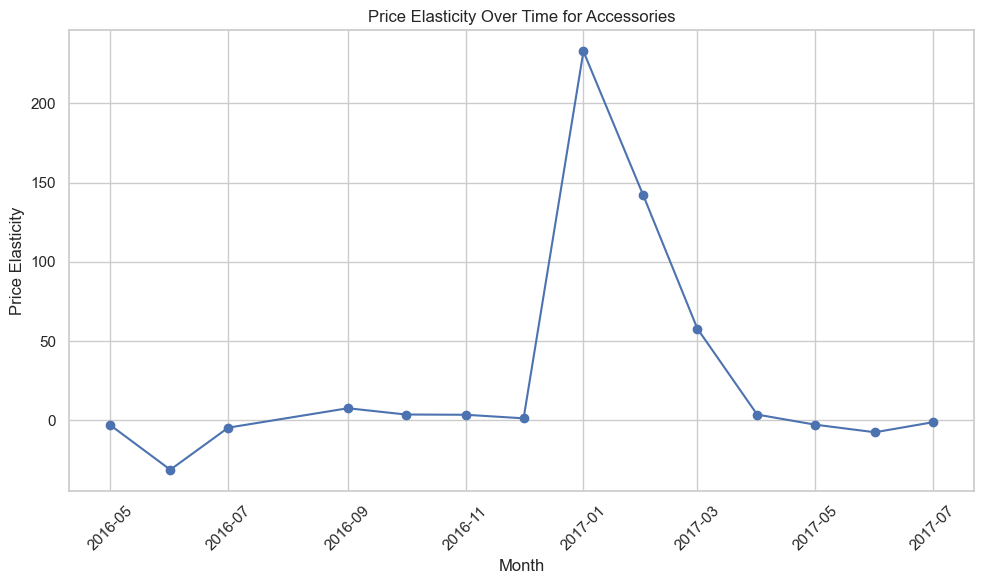

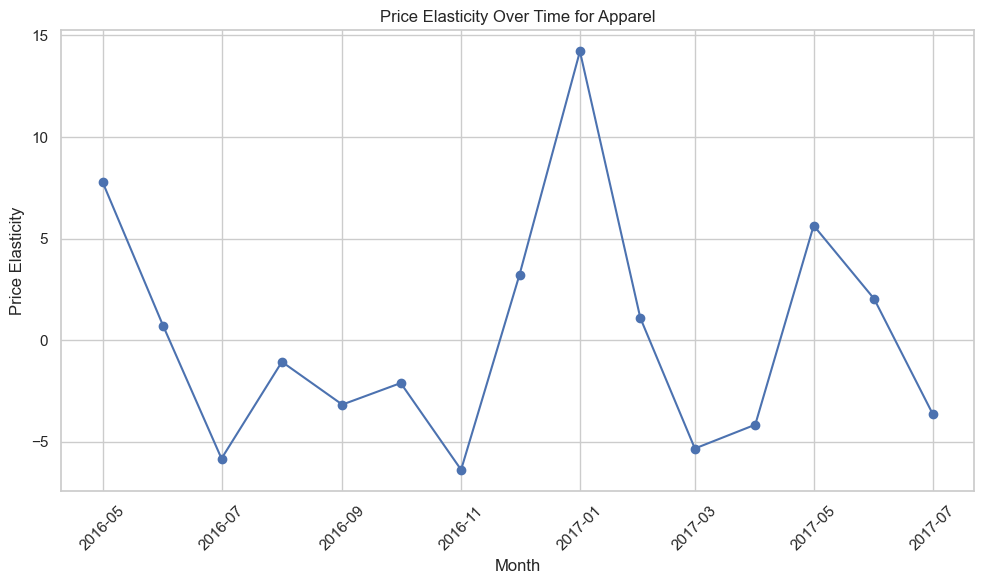

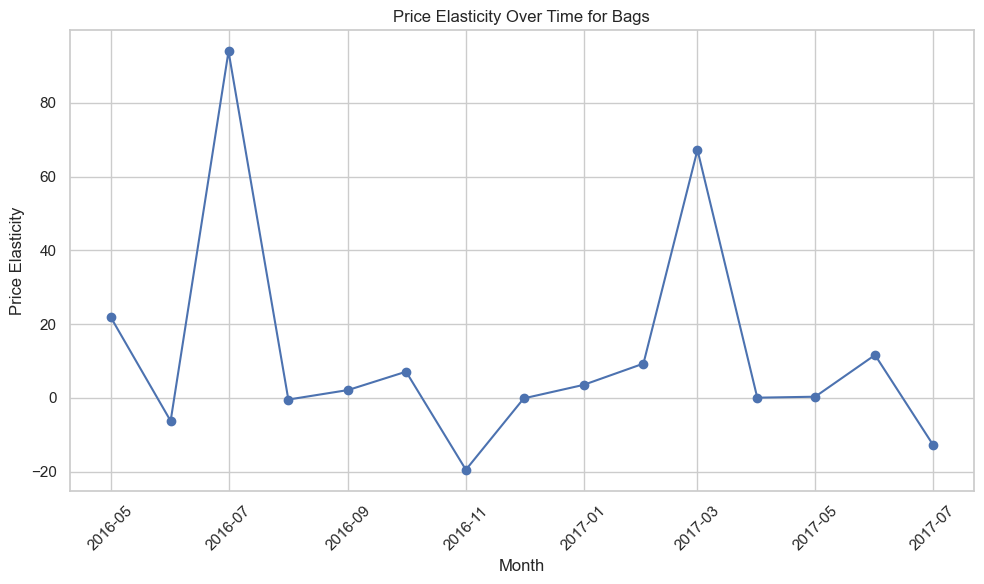

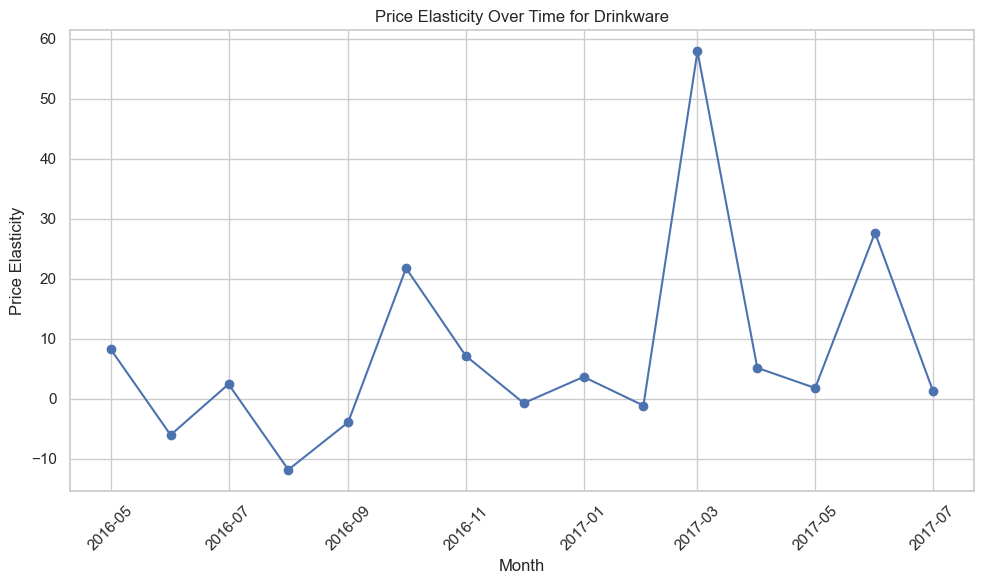

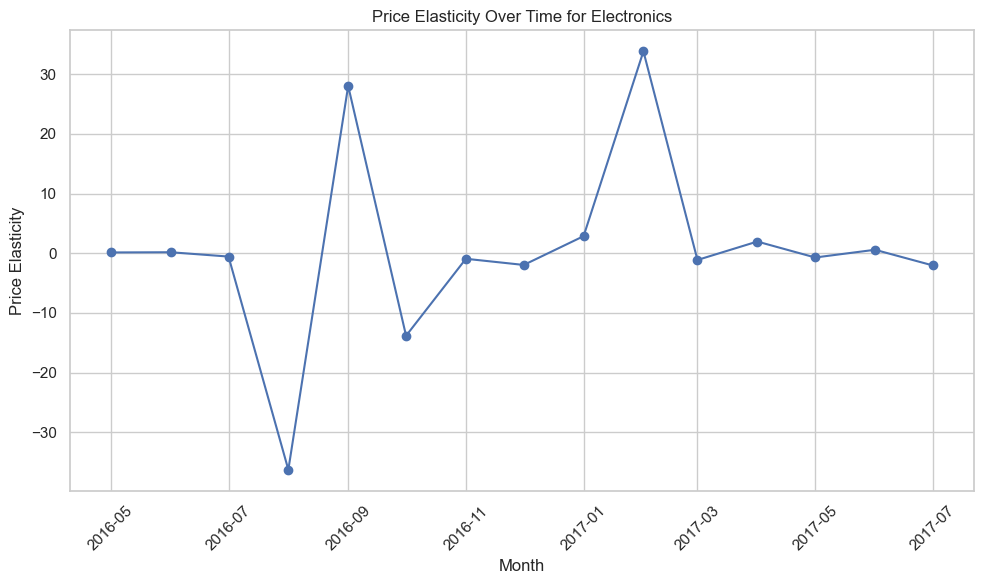

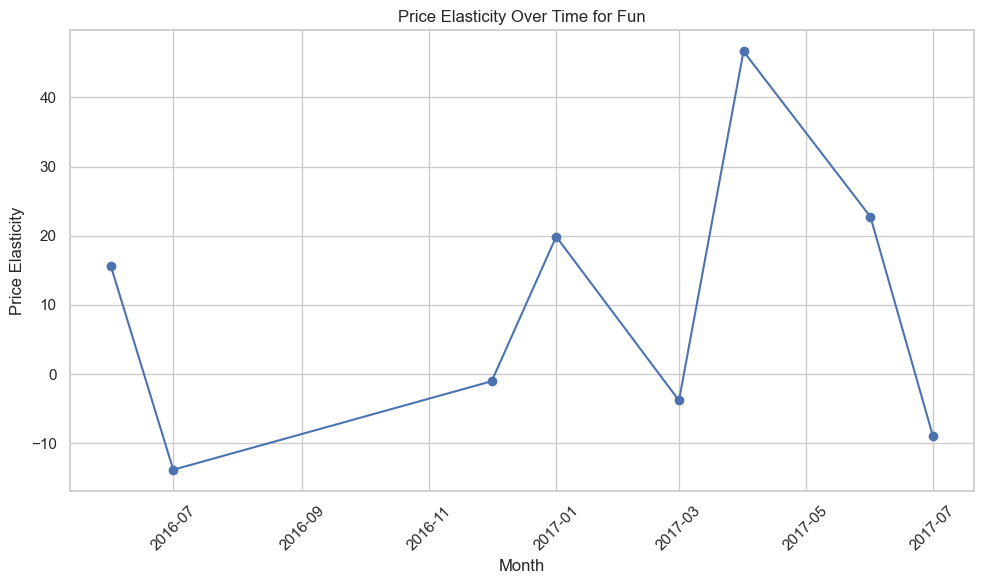

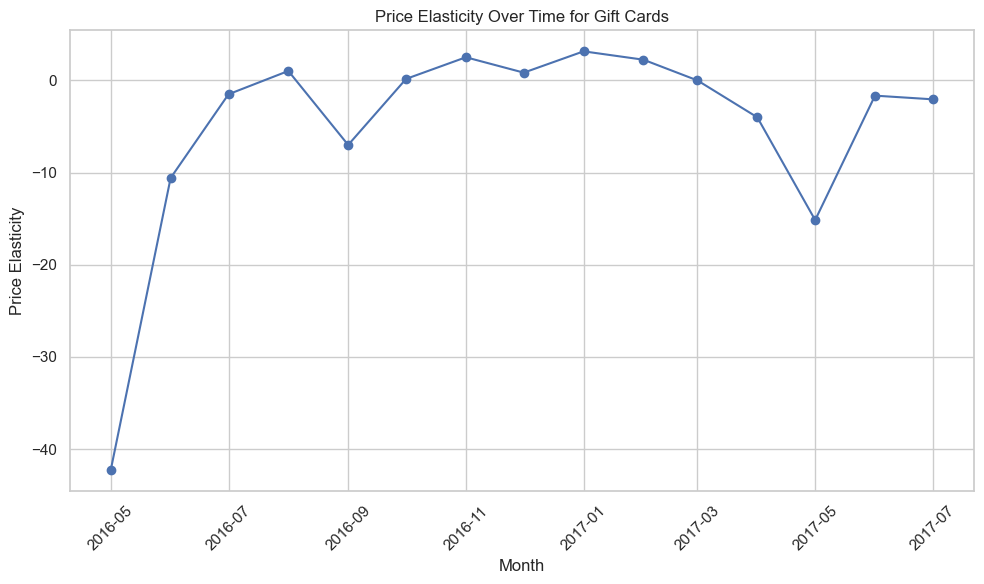

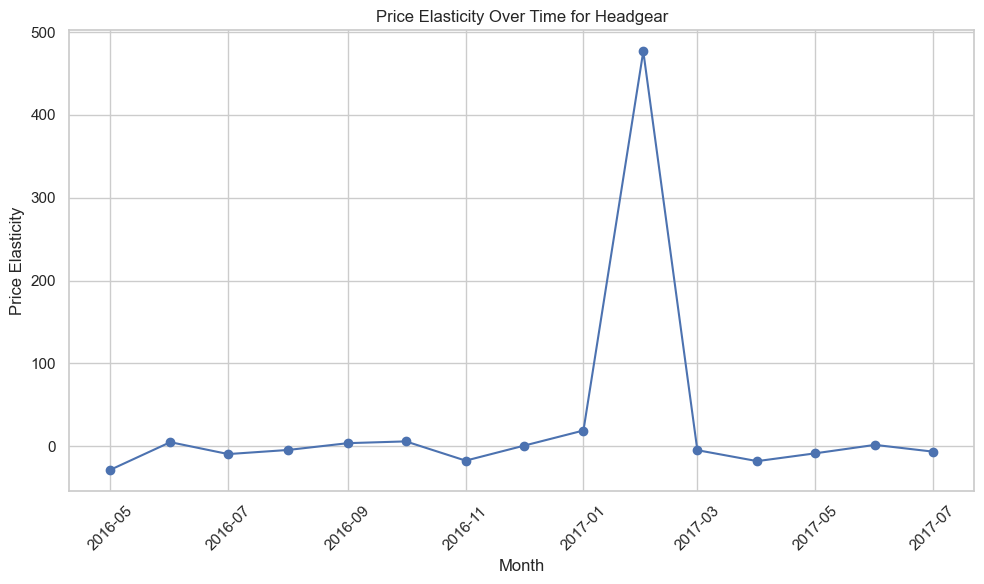

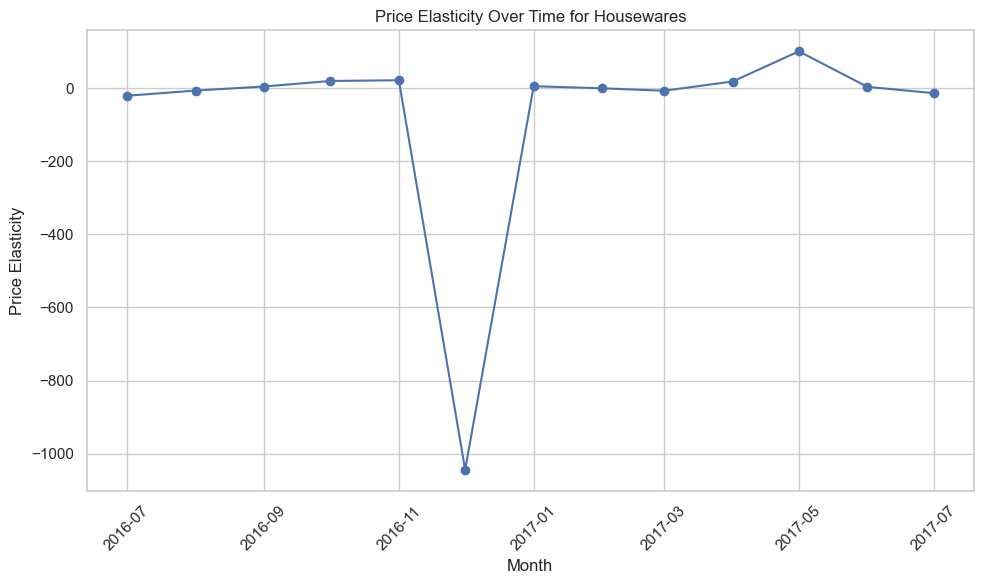

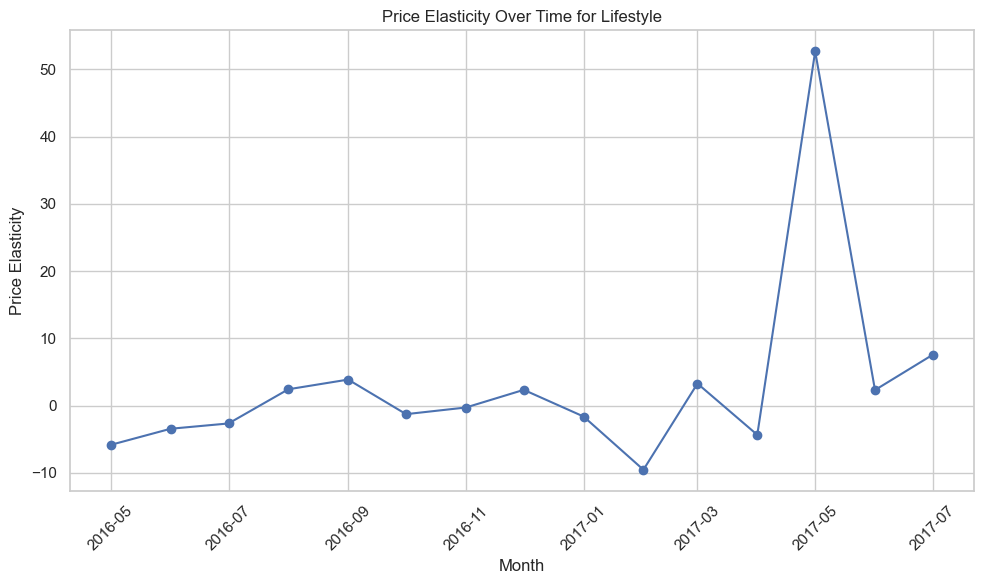

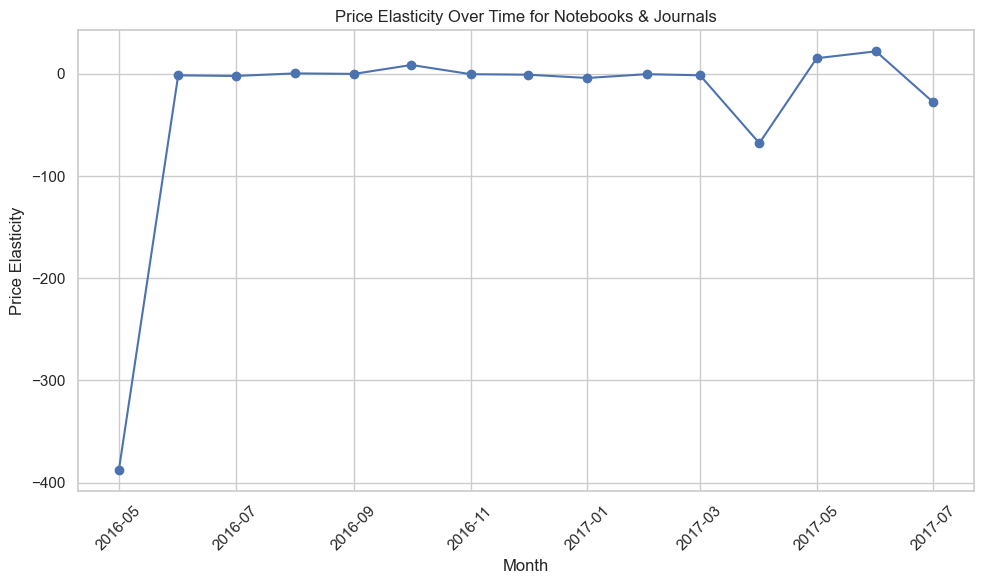

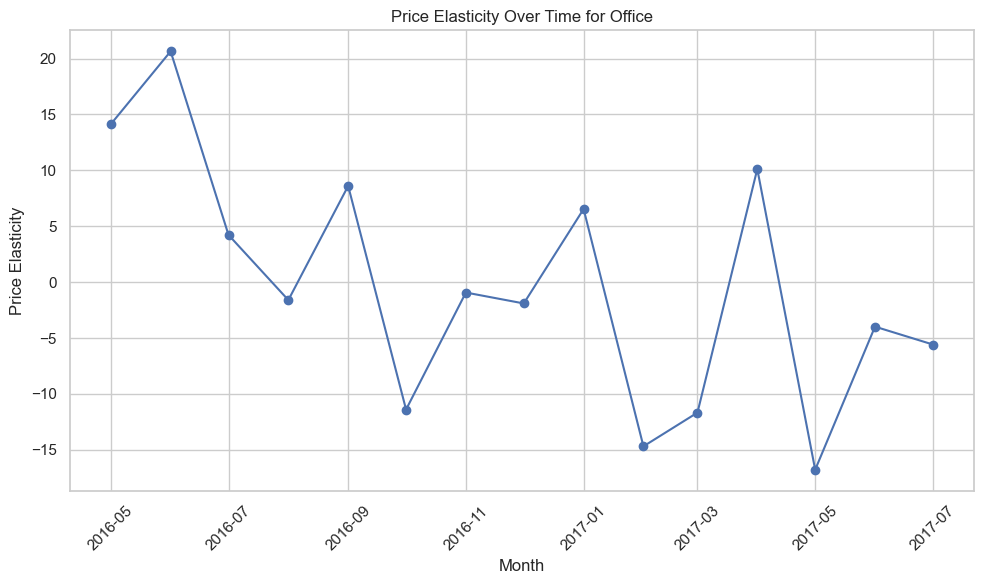

In [18]:
# Set the plot style
sns.set(style="whitegrid")

# Get unique product categories
product_categories = combined_sales_data['product_category'].unique()

# Plot time series of price elasticity for each product category
for category in product_categories:
    plt.figure(figsize=(10, 6))
    
    # Filter data for the specific category
    category_data = combined_sales_data[combined_sales_data['product_category'] == category]
    
    # Plotting price elasticity over time
    plt.plot(category_data['month'], category_data['price_elasticity'], marker='o', linestyle='-')
    
    # Adding titles and labels
    plt.title(f"Price Elasticity Over Time for {category}")
    plt.xlabel("Month")
    plt.ylabel("Price Elasticity")
    plt.xticks(rotation=45)
    
    # Show plot
    plt.tight_layout()
    plt.show()


## 8. Obvservations from Time-Series Analysis

- Price Elasticity for Accessories spike in January 2017 and slowly decrease until March 2017.
- Price Elasticity for Apparel volatile.
- Price Elasticity for Bags has 2 peaks in July 2016 and March 2017.
- Price Elasticity for Drinkware volatile but has high peaks in October 2016, March 2017 and June 2017.
- Price Elasticity for Electronics is stable exempt for dip in August 2016 and peaks in September 2016 and February 2017
- Price Elasticity for Fun products volatile
- Price Elasticity for Gift Cards spike from May 2016 and then maintain stable levels.
- Price Elasticity for Headgear stable except peak in February 2017.
- Price Elasticity for Housewares stable except dip in December 2016.
- Price Elasticity for Lifestyle slowly increasing and spike in May 2017 before decreasing back down.
- Price Elasticity for Notebooks & Journals spiked from May 2016 which was very negative then maintain constant levels.
- Price Elasticity for Office volatile but shows general decrease.

## 9. Possible Insights from Observations
In general, when price elasticites are high, price increase is avoided or very marginal since a small price increase will lead to a large decrease in demand for the good. In contrast, when price elasticities are negative, price increase is encouraged since even though there is price increase, demand for the good will rise. Below are some possible price strategies for product categories with noticable trends.

- Avoid price increase of Accessories in January 2017.
- Avoid price increase of Bags in July 2016 and March 2017.
- Avoid price increase of Drinkware in October 2016, March 2017 and June 2017.
- Encourage price increase of Electronics in August 2016 but avoid price increase in September 2016 and February 2017.
- Avoid price increase for Gift Cards from May 2016.
- Avoid price increase for Headgear in February 2017.
- Encourage price increase in Housewares in December 2016.
- Avoid price increase of Lifestyle products in May 2017.
- Encourage price increase for Notebooks & Journals in May 2016.
- Maybe can slowly increase price of Office products.